In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing modules


In [ ]:
!pip install Levenshtein

     |████████████████████████████████| 258 kB 24.8 MB/s 
     |████████████████████████████████| 2.1 MB 58.8 MB/s 


Downloading Repository

In [2]:
!git clone https://github.com/MehdiSensali/Morse_Data.git
!cp -r /content/Morse_Data/* /content
!cp /content/drive/MyDrive/Projet_Long/dataset_100000_full_wpm.pbz2 /content

Cloning into 'Morse_Data'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 170 (delta 9), reused 144 (delta 3), pack-reused 0
Receiving objects: 100% (170/170), 9.13 MiB | 12.10 MiB/s, done.
Resolving deltas: 100% (9/9), done.


# Data Generation

Imports

In [3]:
# Python Scripts
from config import *
import generate_wav_samples as gen

from tqdm import tqdm
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import bz2
import pickle

Variables

In [4]:
#Length of an audio sample
sample_len = SEQ_LENGTH

#Number of audio samples
samples_count = 100000

dict_len = len(MORSE_CHR)
max_seq_len = 10

#Mel diagram attributs
sr = 8000
mel_count = 10
#Do not modify this value
hop_length = 200
mel_len = 1 + (SEQ_LENGTH//hop_length)

In [5]:
def read_data(set_len, g):
    l = np.zeros([set_len, max_seq_len], dtype=np.int32)
    X = np.zeros([set_len, mel_len, mel_count])
    input_length = np.zeros([set_len, 1], dtype=np.int32)
    label_length = np.zeros([set_len, 1], dtype=np.int32)

    i = 0


    for wave, label_indexes, labels, c, mel in tqdm(g):
        if len(labels) <= max_seq_len:
          X[i, :, :] = mel

          l[i, :len(labels)] = labels
          input_length[i, :] = mel.shape[0]

          label_length[i, :1] = c

          i += 1
        if i == set_len:
            break

    return X, l, input_length, label_length


In [ ]:
dg = gen.DataGenerator()
g = dg.seq_generator(SEQ_LENGTH, FRAMERATE, 1, sr, mel_count)
#X, l, input_length, label_length = read_data(samples_count, g)

In [ ]:
X_test, l_test, input_length_test, label_length_test = read_data(200, g)

199it [00:01, 102.65it/s]


Saving morse data in a file to retrieve it if needed

In [6]:
dataset = f'dataset_{samples_count}_full_wpm'

In [ ]:
if False:
    with bz2.BZ2File(f'{dataset}.pbz2', 'w') as f:
        pickle.dump([X, l, input_length, label_length], f)

In [7]:
if True:
    with bz2.BZ2File(f'{dataset}.pbz2', 'r') as f:
       X, l, input_length, label_length = pickle.load(f)

In [ ]:
print(X.shape)
print(l.shape)
print(input_length[99000][0])
print(label_length[99000][0])


(100000, 161, 10)
(100000, 10)
161
6


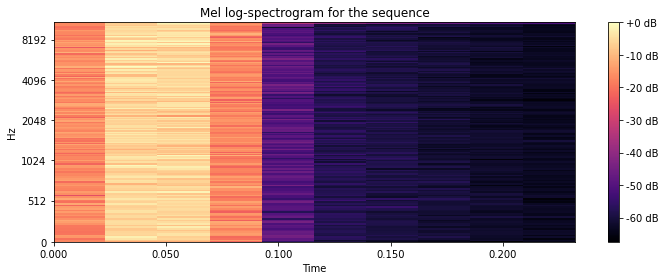

In [8]:
mel_sample = X[10]

plt.figure(figsize=(10, 4))
# Logarithmic scaling in order to identify the signals.
S_dB = librosa.power_to_db(mel_sample , ref=np.max)

# Printing results
librosa.display.specshow(S_dB, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel log-spectrogram for the sequence' )
plt.tight_layout()
plt.show()

# Training

In [ ]:
from tensorflow import keras
import librosa
import librosa.display
import scipy.io.wavfile
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, Add, Concatenate
from tensorflow.keras.layers import Input, Dense, Activation,TimeDistributed, GlobalMaxPooling1D
from tensorflow.keras.layers import Reshape, Lambda, Dropout, Bidirectional, Permute, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GRU, SimpleRNN,LSTM
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.preprocessing import image
import tensorflow.keras.callbacks
import tensorflow.keras.backend as K
import Levenshtein
import string
import pandas as pd
from matplotlib import pyplot

In [ ]:
def cer(true, pred):
    t = ''.join(true).strip()
    p = ''.join(pred).strip()
    distance = Levenshtein.distance(t, p)
    return distance / len(t) if len(t) > 0 else len(p)


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    bc = K.ctc_batch_cost(labels, y_pred, input_length, label_length)
    return bc


def labels_to_text(i):
    return [MORSE_CHR[e] for e in i]


def decode_batch(test_func, word_batch):
    out = test_func([word_batch])[0]
    r = np.argmax(out, axis=-1)
    
    res = []
    for a in r:
        sub_res = []
        for i, e in enumerate(a):
            if i == 0:
                sub_res.append(e)
                continue
            if (e == a[i-1]):
                continue
            if (e == len(MORSE_CHR) - 1):
                continue
            sub_res.append(e)
            
        sub_res = [e for e in sub_res if e != len(MORSE_CHR) - 1]
        sub_res = labels_to_text(sub_res)
        res.append(sub_res)
  
    return res

In [ ]:
OUTPUT_DIR = 'rnn_output'

class VizCallback(tensorflow.keras.callbacks.Callback):
    def __init__(self, run_name, test_func, X):
        self.test_func = test_func
        self.output_dir = os.path.join(
            OUTPUT_DIR, run_name)
        self.X = X

    def on_epoch_end(self, epoch, logs={}):
        self.model.save_weights(os.path.join(self.output_dir, 'weights%02d.h5' % (epoch)))
        
        
        dec_len = 10
        for i in range(dec_len):
            labels = self.X[1][i:i+1]
            print('labels: ', labels_to_text([int(e) for e in labels[0]]))
        
        word_batch = self.X[0][:dec_len]
        res = decode_batch(self.test_func, word_batch)
        print('result lens: ', len(res))
        for e in res[:dec_len]:
            print(e)
        
        len_for_cer_count = 5000
        word_batch = self.X[0][:len_for_cer_count]
        res = decode_batch(self.test_func, word_batch)
        print()
        
        cers = []
        for i, t in enumerate(self.X[1][:len_for_cer_count]):
            true = labels_to_text(t)
            pred = res[i]

            c = cer(true, pred)

            cers.append(c)

        print(np.mean(cers))
            

# Evaluation of the models

First Model

In [ ]:
def get_model_1(optimizer, input_shape=None):
    if input_shape == None:
       input_shape = (mel_len, mel_count)

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')

    conv1 = Conv1D(4, 16, strides=1, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name=f'conv_1', dilation_rate=1)(input_data)

    conv10 = Conv1D(20, 48, strides=1, padding='same',
                    activation=act, kernel_initializer='he_normal',
                    name=f'conv_10', dilation_rate=1)(conv1)

    conv2 = Conv1D(20, 48, strides=1, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name=f'conv_2', dilation_rate=1)(conv10)

    srnn = SimpleRNN(64, return_sequences=True, kernel_initializer='he_normal')(conv2)

    dense1 = Dense(dict_len, kernel_initializer='he_normal', name='dense1')(srnn)

    y_pred = Activation('softmax', name='softmax')(dense1)

    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[max_seq_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    loss_out = Lambda(
        ctc_lambda_func, output_shape=(1,),
        name='ctc')([y_pred, labels, input_length, label_length])

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)

    test_func = K.function([input_data], [y_pred])
    viz_cb = VizCallback('test', test_func, [X_test, l_test, input_length_test, label_length_test])

    return model, viz_cb

In [ ]:
model_1, viz_cb_1 = get_model_1(RMSprop(learning_rate=0.005), input_shape=None)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, 161, 10)]         0         
                                                                 
 conv_1 (Conv1D)             (None, 161, 4)            644       
                                                                 
 conv_10 (Conv1D)            (None, 161, 20)           3860      
                                                                 
 conv_2 (Conv1D)             (None, 161, 20)           19220     
                                                                 
 simple_rnn (SimpleRNN)      (None, 161, 64)           5440      
                                                                 
 dense1 (Dense)              (None, 161, 38)           2470      
                                                                 
 softmax (Activation)        (None, 161, 38)           0     

In [ ]:
model_1.fit([X, l, input_length, label_length], l, validation_split=0.05, batch_size=64, callbacks=[viz_cb_1], epochs=10)

Epoch 1/10
1485/1485 [==============================] - ETA: 0s - loss: 8.4615labels:  ['0', 'Q', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  ['B', 'T', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  ['K', 'W', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  ['1', 'G', 'D', 'T', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  ['E', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  ['A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  ['B', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
result lens:  10
['T', ' ']
[' ']
['T', ' ']
['D', ' ']
[' ']
['9', ' ']
['T', ' ']
['N', ' ']
[' ']
['T', ' ']

0.78875
1485/1485 [==============================] - 286s 191ms/step - loss: 8.4615 - val_loss: 7.9366
Epoch 2/10
1485/1485 [==============================] - ETA: 0s - loss: 7.0078labels:  ['0', 'Q', ' ', ' '

In [ ]:
model_1, _ = get_model_1(RMSprop(lr=0.005), input_shape =None)
model_1.load_weights('./first_model.h5')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, 161, 10)]         0         
                                                                 
 conv_1 (Conv1D)             (None, 161, 4)            644       
                                                                 
 conv_10 (Conv1D)            (None, 161, 20)           3860      
                                                                 
 conv_2 (Conv1D)             (None, 161, 20)           19220     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 161, 64)           5440      
                                                                 
 dense1 (Dense)              (None, 161, 38)           2470      
                                                                 
 softmax (Activation)        (None, 161, 38)           0   

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
test_func_1 = K.function([model_1.get_layer(name="the_input").input], [model_1.get_layer(name="softmax").output])

In [ ]:
def model_evaluation(X_test, test_func, l_test, length):

  for i in range(length):
      labels = l_test[i:i+1]
      print('Sequence', i+1, ': ', labels_to_text([int(e) for e in labels[0]]))


  word_batch = X_test[:length]
  res = decode_batch(test_func, word_batch)
  print('evaluation results: ', len(res))
  for i in range(length):
    print('Prediction', i+1, ': ',res[i])

model_evaluation(X_test, test_func_1, l_test, X_test.shape[0])



Sequence 1 :  ['S', 'I', 'M', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 2 :  ['O', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 3 :  ['X', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 4 :  ['2', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 5 :  [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 6 :  ['B', 'E', 'O', 'P', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 7 :  ['2', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 8 :  [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 9 :  ['D', '6', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 10 :  ['Z', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 11 :  [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 12 :  ['E', 'J', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 13 :  ['C', 'E', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 14 :  ['4', 'I', 'X', 'H', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 15 :  ['O', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 16 :  ['Z'

In [ ]:
def cer_error_evaluation(X_test, test_func, l_test, length=100):
 
  word_batch = X_test[:length]
  res = decode_batch(test_func, word_batch)
  print()
        
  cers = []
  for i, t in enumerate(l_test[:length]):
    true = labels_to_text(t)
    pred = res[i]
    c = cer(true, pred)
    cers.append(c)

  # CER Error calculation
  print("Mean CER Error for:", length, "sample is :",np.mean(cers))

cer_error_evaluation(X_test, test_func_1, l_test, X_test.shape[0])
            


Mean CER Error for: 200 sample is : 0.15941666666666665


Second model

In [ ]:
def get_model_2(optimizer, input_shape=None):
    if input_shape is None:
        input_shape = (mel_len, mel_count)

    # Start of the elementary model
    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    
    conv1 = Conv1D(6, 32, strides = 1, padding='same', 
                        kernel_initializer='he_normal',
                       name=f'conv_1', dilation_rate=1)(input_data)
    bn1 = BatchNormalization()(conv1)
    ac1 = Activation(act)(bn1)
        
    conv2 = Conv1D(16, 64, strides = 1, padding='same', 
                       kernel_initializer='he_normal',
                       name=f'conv_10', dilation_rate=1)(ac1)
    bn2 = BatchNormalization()(conv2)
    ac2 = Activation(act)(bn2)
    
    conv3 = Conv1D(16, 64, strides = 1, padding='same', 
                       kernel_initializer='he_normal',
                       name=f'conv_2', dilation_rate=1)(ac2)
    bn3 = BatchNormalization()(conv3)
    ac3 = Activation(act)(bn3)
    
    srnn = SimpleRNN(38, return_sequences=True, kernel_initializer='he_normal')(ac3)
    dense1 = Dense(dict_len, kernel_initializer='he_normal', name='dense1')(srnn)

    y_pred = Activation('softmax', name='softmax')(dense1)

    Model(inputs=input_data, outputs=y_pred).summary()

    print(y_pred)
    # End of the elementary model to predict probabilities 
    # Adding the elementary model to CTC LOSS Layer
    # Calculation of CTC LOSS by adding layers 

    labels = Input(name='the_labels', shape=[max_seq_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    loss_out = Lambda(
      ctc_lambda_func, output_shape=(1,),
      name='ctc')([y_pred, labels, input_length, label_length])

    model = Model(inputs=[input_data, labels, input_length, label_length] , outputs=loss_out)

    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)


    

    test_func = K.function([input_data], [y_pred])
    viz_cb = VizCallback('test', test_func, [X_test, l_test, input_length_test, label_length_test])
    return model, viz_cb
    


In [ ]:
model_2, viz_cb_2 = get_model_2(RMSprop(lr=0.005), input_shape =None)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, 161, 10)]         0         
                                                                 
 conv_1 (Conv1D)             (None, 161, 6)            1926      
                                                                 
 batch_normalization (BatchN  (None, 161, 6)           24        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 161, 6)            0         
                                                                 
 conv_10 (Conv1D)            (None, 161, 16)           6160      
                                                                 
 batch_normalization_1 (Batc  (None, 161, 16)          64        
 hNormalization)                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 161, 16)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 161, 38)           2090      
                                                                 
 dense1 (Dense)              (None, 161, 38)           1482      
                                                                 
 softmax (Activation)        (None, 161, 38)           0         
                                                                 
Total params: 28,210
Trainable params: 28,134
Non-trainable params: 76
_________________________________________________________________
KerasTensor(type_spec=TensorSpec(shape=(None, 161, 38), dtype=tf.float32, name=None), name='softmax/Softmax:0', description="created by layer 'softmax'")


In [ ]:
model_2.fit([X, l, input_length, label_length], l, validation_split=0.05, batch_size=64, callbacks= [viz_cb_0], epochs=10)

Epoch 1/10
1485/1485 [==============================] - ETA: 0s - loss: 9.4683labels:  ['0', 'Q', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  ['B', 'T', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  ['K', 'W', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  ['1', 'G', 'D', 'T', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  ['E', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  ['A', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
labels:  ['B', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
result lens:  10
['H', ' ']
[' ']
['E', ' ']
['N', ' ']
[' ']
['H', ' ']
['E', ' ']
['N', ' ']
[' ']
['E', ' ']

0.8073333333333333
1485/1485 [==============================] - 354s 236ms/step - loss: 9.4683 - val_loss: 8.1884
Epoch 2/10
1485/1485 [==============================] - ETA: 0s - loss: 7.3992labels:  ['0', 'Q

In [ ]:
model_2, _ = get_model_2(RMSprop(lr=0.005), input_shape =None)
model_2.load_weights('./second_model.h5')

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, 161, 10)]         0         
                                                                 
 conv_1 (Conv1D)             (None, 161, 6)            1926      
                                                                 
 batch_normalization_3 (Batc  (None, 161, 6)           24        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 161, 6)            0         
                                                                 
 conv_10 (Conv1D)            (None, 161, 16)           6160      
                                                                 
 batch_normalization_4 (Batc  (None, 161, 16)          64        
 hNormalization)                                          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Non-trainable params: 76
_________________________________________________________________
KerasTensor(type_spec=TensorSpec(shape=(None, 161, 38), dtype=tf.float32, name=None), name='softmax/Softmax:0', description="created by layer 'softmax'")


In [ ]:
#
test_func_2 = K.function([model_2.get_layer(name="the_input").input], [model_2.get_layer(name="softmax").output])

# equivalente à prediction_model = keras.models.Model(
#    model.get_layer(name="the_input").input, model.get_layer(name="softmax").output
#)

In [ ]:
# 
prediction_model_2= keras.models.Model(
    model_2.get_layer(name="the_input").input, model_2.get_layer(name="dense1").output
)
prediction_model_2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, 161, 10)]         0         
                                                                 
 conv_1 (Conv1D)             (None, 161, 6)            1926      
                                                                 
 batch_normalization_3 (Batc  (None, 161, 6)           24        
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (None, 161, 6)            0         
                                                                 
 conv_10 (Conv1D)            (None, 161, 16)           6160      
                                                                 
 batch_normalization_4 (Batc  (None, 161, 16)          64        
 hNormalization)                                           

In [ ]:
cer_error_evaluation(X_test, test_func_2, l_test, X_test.shape[0])


Mean CER Error for: 200 sample is : 0.05358333333333332


In [ ]:
model_evaluation(X_test, test_func_2, l_test, 10)

Sequence 1 :  ['S', 'I', 'M', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 2 :  ['O', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 3 :  ['X', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 4 :  ['2', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 5 :  [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 6 :  ['B', 'E', 'O', 'P', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 7 :  ['2', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 8 :  [' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 9 :  ['D', '6', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
Sequence 10 :  ['Z', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ']
evaluation results:  10
Prediction 1 :  ['S', 'I', 'M', ' ']
Prediction 2 :  ['O', ' ']
Prediction 3 :  ['X', ' ']
Prediction 4 :  ['2', ' ']
Prediction 5 :  [' ']
Prediction 6 :  ['B', 'E', 'O', 'P', ' ']
Prediction 7 :  ['2', ' ']
Prediction 8 :  [' ']
Prediction 9 :  ['D', '6', ' ']
Prediction 10 :  ['Z', ' ']
